<a href="https://colab.research.google.com/github/fyp-doc-ai/notebooks/blob/main/Copy_of_Fine_tune_LiLT_on_a_custom_dataset%2C_in_any_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up environment

In [ ]:
!pip install -q transformers datasets
!pip install -q evaluate seqeval
!pip install accelerate===0.20.3 -U -q

In [ ]:
!sudo apt install tesseract-ocr-eng
!pip install -q pytesseract
!sudo apt-get install tesseract-ocr-sin

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-eng is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-sin is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
exit()

In [ ]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd =  r'/usr/bin/tesseract'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MAX_SEQ_LENGTH = 512

# Load dataset

## FUNSD

In [ ]:
FUNSD_TRAINING = True

In [ ]:
from datasets import load_dataset

dataset = load_dataset("nielsr/funsd-iob-original")

In [ ]:
label_list = dataset["train"].features["ner_tags"].feature.names
id2label = {id:label for id, label in enumerate(label_list)}
label2id = {label:id for id, label in enumerate(label_list)}
print(id2label)

{0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}


## Our Data

In [ ]:
FUNSD_TRAINING = False

In [ ]:
import pickle

with open('/content/drive/MyDrive/FYP19-DocAI/temp/dataset.pkl', 'rb') as f:
  dataset = pickle.load(f)

In [ ]:
len(dataset[0]['words'])

389

In [ ]:
label_list =  ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
id2label = {id:label for id, label in enumerate(label_list)}
label2id = {label:id for id, label in enumerate(label_list)}
print(id2label)

{0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}


# Create PyTorch Dataset

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torch

def normalize_bbox(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    # get item
    example = self.dataset[idx]
    image = example["image"]
    words = example["words"]
    boxes = example["original_bboxes"]
    ner_tags = example["ner_tags"]

    # prepare for the model
    width, height = image.size

    bbox = []
    labels = []
    for word, box, label in zip(words, boxes, ner_tags):
        box = normalize_bbox(box, width, height)
        n_word_tokens = len(tokenizer.tokenize(word, max_length=MAX_SEQ_LENGTH,  truncation=True))
        bbox.extend([box] * n_word_tokens)
        labels.extend([label] + ([-100] * (n_word_tokens - 1)))

    cls_box = sep_box = [0, 0, 0, 0]
    bbox = [cls_box] + bbox + [sep_box]
    labels = [-100] + labels + [-100]

    encoding = self.tokenizer(" ".join(words), truncation=True, max_length=MAX_SEQ_LENGTH)
    sequence_length = len(encoding.input_ids)
    # truncate boxes and labels based on length of input ids
    labels = labels[:sequence_length]
    bbox = bbox[:sequence_length]

    encoding["bbox"] = bbox
    encoding["labels"] = labels

    return encoding

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("nielsr/lilt-xlm-roberta-base", max_length=MAX_SEQ_LENGTH)

In [ ]:
if FUNSD_TRAINING == True:
  train_dataset = CustomDataset(dataset["train"], tokenizer)
  eval_dataset = CustomDataset(dataset["test"], tokenizer)
else:
  train_dataset = CustomDataset(dataset, tokenizer)
  eval_dataset = CustomDataset(dataset, tokenizer)

In [ ]:
example = train_dataset[0]

In [ ]:
tokenizer.decode(example["input_ids"])

'<s> 2023 වර්ෂයේ දී රජයේ පාසල්වල පළමුවන ශ් රේණියට තම දරුවන් ඇතුළත් කිරීමට බලාපොරොත්තු වන දෙමාපියන් / නිත් යනුකූල භාරකරුවන් මෙම නිවේදනයේ දැක්වෙන උපදෙස් අනුව හා ලබා දී ඇති ආකෘති පත් රයට අනුව සකස් කළ අයදුම්පත් තමන්ට අදාළ වන පාසල්වල ප් රධානීන් වෙත 2022 ජුලි 16 ට ප් රථම ලැබෙන සේ ලියාපදිංචි තැපෑලෙන් ඉදිරිපත් කළ යුතු වේ. සියලු ම සුදුසුකම් සපුරාලිය යුත්තේ 2022 ජූනි 30 දිනට වලංගු වන පරිදිය. අයදුම්පත් පහත දැක්වෙන ආදර්ශ ආකෘති පත් රය අනුව සකස් කළ යුතු ය. අධ් යාපන අමාත් යාංශය 2023 වර්ෂයේ රජයේ පාසල්වල පළමුවන ශ් රේණියට ළමයින් ඇතුළත් කිරීම පිළිබඳ උපදෙස් 2.2 02. ළමයා පිළිබඳ විස්තර : 2.1 2.3 2023 වර්ෂයේ දී ( ළමයාගේ උප්පැන්න සහතිකයේ පිටපතක් හා තමා ඉල්ලුම් කරනු ලබන ගණය යටතේ, අදාළ වන සියලු ම ලිපි ලේඛනවල පිටපත්, දිව්රුම් ප් රකාශයක් මඟින් සහතික කර මෙයට අමුණා එවිය යුතු ය. ) 01. ඉල්ලුම් කරන ගණය : ( ගණ කිහිපයකට අයත් නම් වෙන වෙන ම ඉල්ලුම් කළ යුතු ය. ) 3.1 කො / රාජකීය පළමුවන ශ් රේණියට ඇතුළත් කිරීම සඳහා අයදුම් පත් රය 2.4 ස්ත් රී / පුරුෂ භාවය : 2.5 ආගම : බෞද්ධ 2.6 ඉගෙනුම් මාධ් යය ( සිංහල / දෙමළ ) 2.7 2018 උපන්දිනය 

In [ ]:
for k,v in example.items():
  print(k,len(v))

input_ids 512
attention_mask 512
bbox 512
labels 512


In [ ]:
if FUNSD_TRAINING == True:
  for word, box, label in zip(dataset["train"][0]["words"], dataset["train"][0]["original_bboxes"], dataset["train"][0]["ner_tags"]):
    print(word, box, id2label[label])
else:
  for word, box, label in zip(dataset[0]["words"], dataset[0]["original_bboxes"], dataset[0]["ner_tags"]):
    print(word, box, id2label[label])

2023 [135, 355, 182, 377] O
වර්ෂයේ [198, 355, 272, 377] O
දී [286, 355, 295, 377] O
රජයේ [311, 355, 370, 377] O
පාසල්වල [384, 355, 472, 377] O
පළමුවන [488, 355, 569, 377] O
ශ්‍රේණියට [585, 355, 671, 377] O
තම [687, 355, 718, 377] O
දරුවන් [734, 355, 799, 377] O
ඇතුළත් [814, 355, 888, 377] O
කිරීමට [903, 355, 966, 377] O
බලාපොරොත්තු [982, 355, 1131, 377] O
වන [1147, 355, 1178, 377] O
දෙමාපියන් [60, 383, 159, 406] O
/ [159, 383, 169, 406] O
නිත්‍යනුකූල [173, 383, 276, 406] O
භාරකරුවන් [289, 383, 402, 406] O
මෙම [413, 383, 458, 406] O
නිවේදනයේ [470, 383, 581, 406] O
දැක්වෙන [592, 383, 678, 406] O
උපදෙස් [690, 383, 764, 406] O
අනුව [774, 383, 821, 406] O
හා [832, 383, 850, 406] O
ලබා [865, 383, 904, 406] O
දී [916, 383, 925, 406] O
ඇති [936, 383, 972, 406] O
ආකෘති [984, 383, 1049, 406] O
පත්‍රයට [1060, 383, 1121, 406] O
අනුව [1133, 383, 1179, 406] O
සකස් [60, 413, 112, 435] O
කළ [125, 413, 159, 435] O
අයදුම්පත් [174, 413, 264, 435] O
තමන්ට [278, 413, 345, 435] O
අදාළ [360, 413, 407, 435] O

In [ ]:
len(example["input_ids"])

512

In [ ]:
for id, box, label in zip(example["input_ids"], example["bbox"], example["labels"]):
  if label != -100:
    print(tokenizer.decode([id]), box, id2label[label])
  else:
    print(tokenizer.decode([id]), box, -100)

<s> [0, 0, 0, 0] -100
2023 [108, 202, 146, 214] O
වර්ෂ [159, 202, 219, 214] O
යේ [159, 202, 219, 214] -100
දී [230, 202, 237, 214] O
රජයේ [250, 202, 298, 214] O
පාසල් [309, 202, 380, 214] O
වල [309, 202, 380, 214] -100
පළමු [393, 202, 458, 214] O
වන [393, 202, 458, 214] -100
ශ් [471, 202, 540, 214] O
රේ [471, 202, 540, 214] -100
ණිය [471, 202, 540, 214] -100
ට [471, 202, 540, 214] -100
තම [553, 202, 578, 214] O
දරුවන් [591, 202, 643, 214] O
ඇතුළත් [655, 202, 715, 214] O
කිරීමට [727, 202, 778, 214] O
බලාපොරොත්තු [791, 202, 911, 214] O
වන [924, 202, 949, 214] O
දෙ [48, 218, 128, 231] O
මා [48, 218, 128, 231] -100
පි [48, 218, 128, 231] -100
යන් [48, 218, 128, 231] -100
/ [128, 218, 136, 231] O
නි [139, 218, 222, 231] O
ත් [139, 218, 222, 231] -100
යනු [139, 218, 222, 231] -100
කූල [139, 218, 222, 231] -100
භාර [232, 218, 323, 231] O
කරුවන් [232, 218, 323, 231] -100
මෙම [332, 218, 369, 231] O
නිවේදනය [378, 218, 468, 231] O
ේ [378, 218, 468, 231] -100
දැක් [477, 218, 546, 231] O
වෙන [477, 

# Define PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(features):
  boxes = [feature["bbox"] for feature in features]
  labels = [feature["labels"] for feature in features]
  # use tokenizer to pad input_ids
  batch = tokenizer.pad(features, padding="max_length", max_length=MAX_SEQ_LENGTH)

  sequence_length = torch.tensor(batch["input_ids"]).shape[1]
  batch["labels"] = [labels_example + [-100] * (sequence_length - len(labels_example)) for labels_example in labels]
  batch["bbox"] = [boxes_example + [[0, 0, 0, 0]] * (sequence_length - len(boxes_example)) for boxes_example in boxes]

  # convert to PyTorch
  # batch = {k: torch.tensor(v, dtype=torch.int64) if isinstance(v[0], list) else v for k, v in batch.items()}
  batch = {k: torch.tensor(v) for k, v in batch.items()}

  return batch

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
eval_dataloader = DataLoader(eval_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [ ]:
batch = next(iter(train_dataloader))

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
bbox torch.Size([2, 512, 4])
labels torch.Size([2, 512])


In [ ]:
tokenizer.decode(batch["input_ids"][0])

'<s> 2023 වර්ෂයේ දී රජයේ පාසල්වල පළමුවන ශ් රේණියට තම දරුවන් ඇතුළත් කිරීමට බලාපොරොත්තු වන දෙමාපියන් / නිත් යනුකූල භාරකරුවන් මෙම නිවේදනයේ දැක්වෙන උපදෙස් අනුව හා ලබා දී ඇති ආකෘති පත් රයට අනුව සකස් කළ අයදුම්පත් තමන්ට අදාළ වන පාසල්වල ප් රධානීන් වෙත 2022 ජුලි 16 ට ප් රථම ලැබෙන සේ ලියාපදිංචි තැපෑලෙන් ඉදිරිපත් කළ යුතු වේ. සියලු ම සුදුසුකම් සපුරාලිය යුත්තේ 2022 ජූනි 30 දිනට වලංගු වන පරිදිය. අයදුම්පත් පහත දැක්වෙන ආදර්ශ ආකෘති පත් රය අනුව සකස් කළ යුතු ය. අධ් යාපන අමාත් යාංශය 2023 වර්ෂයේ රජයේ පාසල්වල පළමුවන ශ් රේණියට ළමයින් ඇතුළත් කිරීම පිළිබඳ උපදෙස් 2.2 02. ළමයා පිළිබඳ විස්තර : 2.1 2.3 2023 වර්ෂයේ දී ( ළමයාගේ උප්පැන්න සහතිකයේ පිටපතක් හා තමා ඉල්ලුම් කරනු ලබන ගණය යටතේ, අදාළ වන සියලු ම ලිපි ලේඛනවල පිටපත්, දිව්රුම් ප් රකාශයක් මඟින් සහතික කර මෙයට අමුණා එවිය යුතු ය. ) 01. ඉල්ලුම් කරන ගණය : ( ගණ කිහිපයකට අයත් නම් වෙන වෙන ම ඉල්ලුම් කළ යුතු ය. ) 3.1 කො / රාජකීය පළමුවන ශ් රේණියට ඇතුළත් කිරීම සඳහා අයදුම් පත් රය 2.4 ස්ත් රී / පුරුෂ භාවය : 2.5 ආගම : බෞද්ධ 2.6 ඉගෙනුම් මාධ් යය ( සිංහල / දෙමළ ) 2.7 2018 උපන්දිනය 

In [ ]:
for id, box, label in zip(batch["input_ids"][0], batch["bbox"][0], batch["labels"][0]):
  if label.item() != -100:
    print(tokenizer.decode([id]), box, id2label[label.item()])
  else:
    print(tokenizer.decode([id]), box, label.item())

<s> tensor([0, 0, 0, 0]) -100
2023 tensor([108, 202, 146, 214]) O
වර්ෂ tensor([159, 202, 219, 214]) O
යේ tensor([159, 202, 219, 214]) -100
දී tensor([230, 202, 237, 214]) O
රජයේ tensor([250, 202, 298, 214]) O
පාසල් tensor([309, 202, 380, 214]) O
වල tensor([309, 202, 380, 214]) -100
පළමු tensor([393, 202, 458, 214]) O
වන tensor([393, 202, 458, 214]) -100
ශ් tensor([471, 202, 540, 214]) O
රේ tensor([471, 202, 540, 214]) -100
ණිය tensor([471, 202, 540, 214]) -100
ට tensor([471, 202, 540, 214]) -100
තම tensor([553, 202, 578, 214]) O
දරුවන් tensor([591, 202, 643, 214]) O
ඇතුළත් tensor([655, 202, 715, 214]) O
කිරීමට tensor([727, 202, 778, 214]) O
බලාපොරොත්තු tensor([791, 202, 911, 214]) O
වන tensor([924, 202, 949, 214]) O
දෙ tensor([ 48, 218, 128, 231]) O
මා tensor([ 48, 218, 128, 231]) -100
පි tensor([ 48, 218, 128, 231]) -100
යන් tensor([ 48, 218, 128, 231]) -100
/ tensor([128, 218, 136, 231]) O
නි tensor([139, 218, 222, 231]) O
ත් tensor([139, 218, 222, 231]) -100
යනු tensor([139, 218, 22

# Define model

In [ ]:
from transformers import LiltForTokenClassification

model = LiltForTokenClassification.from_pretrained("pierreguillou/lilt-xlm-roberta-base-finetuned-funsd-iob-original", id2label=id2label, label2id=label2id, max_position_embeddings=MAX_SEQ_LENGTH+2, ignore_mismatched_sizes=True)

# Train the model in native PyTorch

Uncomment the code below if you want to train the model just in native PyTorch.

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# optimizer = torch.optim.AdamW(model.parameters(), lr=5-5)

# model.train()
# for epoch in range(2):
#   for batch in train_dataloader:
#       # zero the parameter gradients
#       optimizer.zero_grad()

#       inputs = {k:v.to(device) for k,v in batch.items()}

#       outputs = model(**inputs)

#       loss = outputs.loss
#       loss.backward()

#       optimizer.step()

# Train the model using 🤗 Trainer

We first define a compute_metrics function as well as TrainingArguments.

In [ ]:
import evaluate

metric = evaluate.load("seqeval")

In [ ]:
import numpy as np
from seqeval.metrics import classification_report

return_entity_level_metrics = False

def compute_metrics(p):
    # global tp, tl
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # tl = true_labels
    # tp = true_predictions

    # print(tp[0])
    # print(tl[0])

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  num_train_epochs=30,
                                  learning_rate=5e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

Next we define a custom Trainer which uses the DataLoaders we created above.

In [ ]:
from transformers.data.data_collator import default_data_collator

class CustomTrainer(Trainer):
  def get_train_dataloader(self):
    return train_dataloader

  def get_eval_dataloader(self, eval_dataset = None):
    return eval_dataloader

# Initialize our Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=30, training_loss=0.34396692911783855, metrics={'train_runtime': 14.0378, 'train_samples_per_second': 4.274, 'train_steps_per_second': 2.137, 'total_flos': 16689767362560.0, 'train_loss': 0.34396692911783855, 'epoch': 30.0})

In [ ]:
if FUNSD_TRAINING:
  OUTPUT_DIR = '/content/drive/MyDrive/FYP19-DocAI/temp/pre-trained'
else:
  OUTPUT_DIR = '/content/drive/MyDrive/FYP19-DocAI/temp/fine-tuned'
trainer.save_model(OUTPUT_DIR)

# Inference

In [ ]:
from transformers import LiltForTokenClassification, AutoTokenizer
from PIL import Image, ImageDraw, ImageFont
import torch
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
image = Image.open('/content/drive/MyDrive/FYP19-DocAI/temp/image_001.jpg')

In [ ]:
!tesseract --list-langs

List of available languages (3):
eng
osd
sin


In [ ]:
width, height = image.size
w_scale = 1000/width
h_scale = 1000/height

ocr_df = pytesseract.image_to_data(image, output_type='data.frame', lang='eng+sin')

ocr_df = ocr_df.dropna() \
               .assign(left_scaled = ocr_df.left*w_scale,
                       width_scaled = ocr_df.width*w_scale,
                       top_scaled = ocr_df.top*h_scale,
                       height_scaled = ocr_df.height*h_scale,
                       right_scaled = lambda x: x.left_scaled + x.width_scaled,
                       bottom_scaled = lambda x: x.top_scaled + x.height_scaled)

float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
ocr_df = ocr_df.dropna().reset_index(drop=True)
# ocr_df[:20]

In [ ]:
len(ocr_df)

189

In [ ]:
words = list(ocr_df.text)
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
  x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
  actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box
  actual_boxes.append(actual_box)

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

boxes = []
for box in actual_boxes:
  boxes.append(normalize_box(box, width, height))
# boxes

In [ ]:
def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, args, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
      width, height = image.size

      tokens = []
      token_boxes = []
      actual_bboxes = [] # we use an extra b because actual_boxes is already used
      token_actual_boxes = []
      for word, box, actual_bbox in zip(words, boxes, actual_boxes):
          word_tokens = tokenizer.tokenize(word)
          tokens.extend(word_tokens)
          token_boxes.extend([box] * len(word_tokens))
          actual_bboxes.extend([actual_bbox] * len(word_tokens))
          token_actual_boxes.extend([actual_bbox] * len(word_tokens))

      # Truncation: account for [CLS] and [SEP] with "- 2".
      special_tokens_count = 2
      if len(tokens) > args.max_seq_length - special_tokens_count:
          tokens = tokens[: (args.max_seq_length - special_tokens_count)]
          token_boxes = token_boxes[: (args.max_seq_length - special_tokens_count)]
          actual_bboxes = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
          token_actual_boxes = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]

      # add [SEP] token, with corresponding token boxes and actual boxes
      tokens += [tokenizer.sep_token]
      token_boxes += [sep_token_box]
      actual_bboxes += [[0, 0, width, height]]
      token_actual_boxes += [[0, 0, width, height]]

      segment_ids = [0] * len(tokens)

      # next: [CLS] token
      tokens = [tokenizer.cls_token] + tokens
      token_boxes = [cls_token_box] + token_boxes
      actual_bboxes = [[0, 0, width, height]] + actual_bboxes
      token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
      segment_ids = [1] + segment_ids

      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      input_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = args.max_seq_length - len(input_ids)
      input_ids += [tokenizer.pad_token_id] * padding_length
      input_mask += [0] * padding_length
      segment_ids += [tokenizer.pad_token_id] * padding_length
      token_boxes += [pad_token_box] * padding_length
      token_actual_boxes += [pad_token_box] * padding_length

      assert len(input_ids) == args.max_seq_length
      assert len(input_mask) == args.max_seq_length
      assert len(segment_ids) == args.max_seq_length
      #assert len(label_ids) == args.max_seq_length
      assert len(token_boxes) == args.max_seq_length
      assert len(token_actual_boxes) == args.max_seq_length

      return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("nielsr/lilt-xlm-roberta-base")

In [ ]:
args = {
        'max_seq_length': 512,
}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

In [ ]:
input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image, words=words, boxes=boxes, actual_boxes=actual_boxes, tokenizer=tokenizer, args=args)

In [ ]:
tokenizer.decode(input_ids)

'<s> ග් රාමසංවර්ධන අභ් යාස හා පර්යේෂණ ආයතනය පුහුණු වැඩසටහන් ඉල්ලුම් කිරීම සඳහා අයදුම් පත් රය අයදුම්කරන පුහුණු වැඩසටහනේ නම :-..... ඔහුම. සහභාගිවීමට කැමති පුගුණු මධාංස්ථානය :. මුලකරු සමඟ නම :~ ස්ත් රී/ පුරුෂ බව :-... ජාතික හැඳුනුම්පත් අංකය : ලබා ඇති ඉහළම අධා් යාපන සුදුසුකම සේවය කරන ආයතනයේ නම :- දැනට දරන තනතුර :-~........ මී. රාජකාරි ලිපිනය : මාර්ග සංවර්ධන අධිකාරිය, කුරුණෑගල මාර්ග සංවර්ධන අධිකාරිය පි ද අය නැ. 2 සං 1: අම: අ. දුරකථන අංකය ::. ෆැක්ස් අංකය :-........037-2230610ඌ. පෞද්ගලික ලිපිනය :ං ee ro ය wv කූ wo - පුද්ගලික දුරක ථන අංක, i eee පුගුණු වැඩසටහනට සම්බන්ධ පත තා කරන gouen මෑ න්ධ නව බාධයක් නී කූ දක ඉහත සඳහන් කරුණු සන් ය් යං ගා නිවරදි බව සහතික කරන අතර අදාළ පුගුණු වැඩසටහනට තෝරාගනු ලැබුවහොත් පුහුණු ආයතනයේ නීතිරීතිවලට එකඟව කටයුතු කිරීමට පොරොන්දු වෙමි. 2023/08/28 [ ෴෴2 ඳිනය අයදුම්කරුගේ. අත්සන ආයතන ප් රධානියාගේ සහතිකය අධාක් ක්ෂ ග් රාමසංවර්ධන අභ් යාස ගා පර්යේෂණ ආයතනය පී. ජී. එම්. එස්. ගුණරත්න මෙම ආයතනයේ සේවය කරන "මංකාකරෙතාකෂමණමෙනවිය පුහුණු වැඩසටහන හැදෑරීම ඔහුගේ/ඇයගේ සේවා කටයුතු කෙරෙගි ඵලදා

In [ ]:
input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
input_ids.shape

torch.Size([1, 512])

In [ ]:
attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
attention_mask.shape

torch.Size([1, 512])

In [ ]:
token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
token_type_ids.shape

torch.Size([1, 512])

In [ ]:
bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)
bbox.shape

torch.Size([1, 512, 4])

In [ ]:
model = LiltForTokenClassification.from_pretrained(OUTPUT_DIR)
model.to(device)

LiltForTokenClassification(
  (lilt): LiltModel(
    (embeddings): LiltTextEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layout_embeddings): LiltLayoutEmbeddings(
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (box_position_embeddings): Embedding(514, 192, padding_idx=1)
      (box_linear_embeddings): Linear(in_features=768, out_features=192, bias=True)
      (LayerNorm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LiltEncoder(
      (layer): ModuleList(
        (0-11): 12 x Li

In [ ]:
outputs = model(input_ids=input_ids.to(device), bbox=bbox.to(device), attention_mask=attention_mask.to(device))
outputs

TokenClassifierOutput(loss=None, logits=tensor([[[ 0.9604, -1.0732, -0.4427,  ...,  0.2124, -0.0277, -0.1506],
         [-1.2598,  5.7560,  1.8155,  ..., -2.2918,  1.2276, -3.1457],
         [-0.1191, -2.2371,  7.4897,  ..., -0.2359, -2.0874,  0.3311],
         ...,
         [ 1.1739, -1.2415, -0.5845,  ...,  0.3710, -0.0723, -0.1379],
         [ 1.1739, -1.2415, -0.5845,  ...,  0.3710, -0.0723, -0.1379],
         [ 1.1739, -1.2415, -0.5845,  ...,  0.3710, -0.0723, -0.1379]]],
       device='cuda:0', grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

In [ ]:
outputs.logits.shape

torch.Size([1, 512, 7])

In [ ]:
outputs.logits.argmax(-1)

tensor([[0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4,
         4, 4, 4, 4, 4, 5, 5, 6, 6, 3, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4,
         4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 6, 5, 6, 3,
         4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 3, 0, 4, 0, 0, 0, 3, 4, 4, 4,
         5, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6, 6, 6, 5,
         0, 3, 4, 4, 4, 5, 0, 0, 0, 5, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 4, 4, 1, 2, 2, 2, 2,
         2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 5, 6, 6, 6, 6, 6,
         6, 6, 6, 6, 6, 6, 6

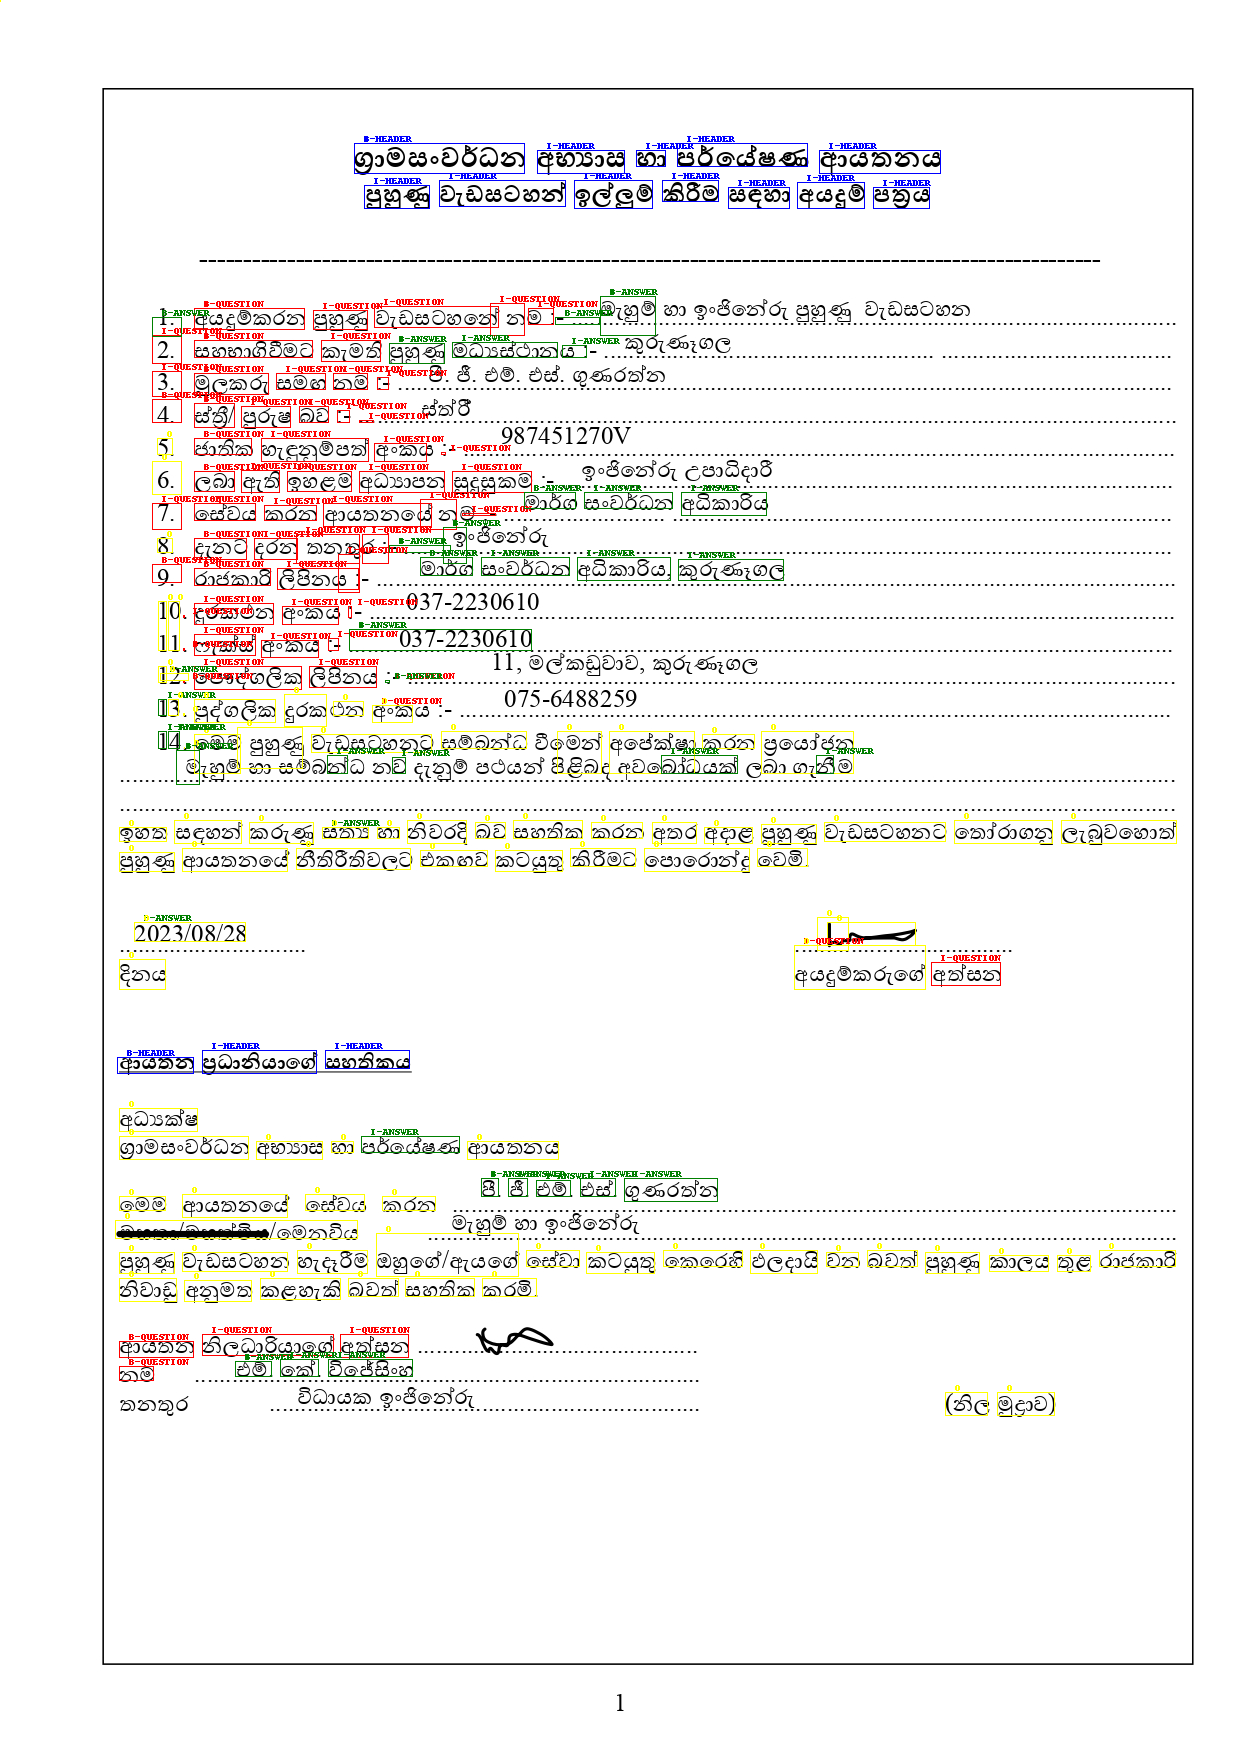

In [ ]:
label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
    "O": "yellow"
}

# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

def draw_boxes(image, boxes, predictions):
  width, height = image.size
  normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

  # draw predictions over the image
  draw = ImageDraw.Draw(image)
  font = ImageFont.load_default()
  for prediction, box in zip(predictions, normalizes_boxes):
      # if prediction == "O":
      #     continue
      draw.rectangle(box, outline="black")
      draw.rectangle(box, outline=label2color[prediction])
      draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
  return image

predictions = outputs.logits.argmax(-1).squeeze().tolist()

# get labels
labels = [model.config.id2label[prediction] for prediction in predictions]
display(draw_boxes(image, bbox[0], labels))

In [ ]:
outputs.logits.argmax(-1).shape

torch.Size([1, 512])

# Debugging

In [ ]:
import evaluate

metric = evaluate.load("seqeval")

In [ ]:
import pickle
with open('/content/drive/MyDrive/FYP19-DocAI/temp/tl.pkl', 'rb') as f:
  tl = pickle.load(f)

with open('/content/drive/MyDrive/FYP19-DocAI/temp/tp.pkl', 'rb') as f:
  tp = pickle.load(f)

In [ ]:
metric.compute(predictions=tp, references=tl)

In [ ]:
len(tp[0])

In [ ]:
len(tl[0])

In [ ]:
set(tp[0])

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))